# Part 1: Data exploration

In [1]:
# Install kaggle
#! pip install kaggle

# Check if the .kaggle directory already exists and contains the kaggle.json file
import os

kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')


if os.path.exists(kaggle_json_path):
    print("kaggle.json file already exists in the .kaggle directory. Skipping copy.")
else:
    # If the kaggle.json file is not present, provide the correct path to copy it
    source_kaggle_json_path = r'C:/Users/playb/.kaggle/kaggle.json'  # Change this to the actual path
    shutil.copy(source_kaggle_json_path, kaggle_json_path)

# Download the dataset using Kaggle API
! kaggle competitions download -c state-farm-distracted-driver-detection

kaggle.json file already exists in the .kaggle directory. Skipping copy.




  0%|          | 0.00/4.00G [00:00<?, ?B/s]
  0%|          | 1.00M/4.00G [00:01<1:36:29, 742kB/s]
  0%|          | 2.00M/4.00G [00:01<47:56, 1.49MB/s] 
  0%|          | 3.00M/4.00G [00:01<29:48, 2.40MB/s]
  0%|          | 5.00M/4.00G [00:01<15:52, 4.51MB/s]
  0%|          | 8.00M/4.00G [00:02<08:58, 7.96MB/s]
  0%|          | 10.0M/4.00G [00:02<07:14, 9.86MB/s]
  0%|          | 12.0M/4.00G [00:02<06:01, 11.8MB/s]
  0%|          | 14.0M/4.00G [00:02<05:16, 13.5MB/s]
  0%|          | 16.0M/4.00G [00:02<04:51, 14.7MB/s]
  0%|          | 19.0M/4.00G [00:02<04:13, 16.9MB/s]
  1%|          | 21.0M/4.00G [00:02<04:56, 14.4MB/s]
  1%|          | 25.0M/4.00G [00:03<04:07, 17.3MB/s]
  1%|          | 28.0M/4.00G [00:03<03:34, 19.9MB/s]
  1%|          | 31.0M/4.00G [00:03<03:35, 19.8MB/s]
  1%|          | 34.0M/4.00G [00:03<03:34, 19.8MB/s]
  1%|          | 36.0M/4.00G [00:03<03:33, 19.9MB/s]
  1%|          | 38.0M/4.00G [00:03<03:34, 19.9MB/s]
  1%|          | 40.0M/4.00G [00:03<04:03, 17.5MB/s]

In [2]:
# Unzip the downloaded file
import zipfile

with zipfile.ZipFile('state-farm-distracted-driver-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('state-farm-distracted-driver-detection')

In [3]:
# Install necessary libraries (use only if required in your environment)
# !pip install opencv-python
# !pip install scikit-image
# !pip install tensorflow
# !pip install visualkeras

# Core libraries for machine learning, deep learning, and computer vision
import os
import sys
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, EfficientNetB3, VGG16
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers, Model

# Preprocessing input specific to model architectures
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_Inceptionv3
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_input_IresnetV2

# Visualization and Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import visualkeras
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
train_path="state-farm-distracted-driver-detection/imgs/train"

classes_dict={
    0: "safe driving",
    1: "texting  right",
    2: "talking on the phone - right",
    3: "texting  left",
    4: "talking on the phone - left",
    5: "operating the radio",
    6: "drinking",
    7: "reaching behind",
    8: "hair and makeup",
    9: "talking to passenger",
}

In [5]:
df_driver=pd.read_csv('state-farm-distracted-driver-detection/driver_imgs_list.csv')
df_driver.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


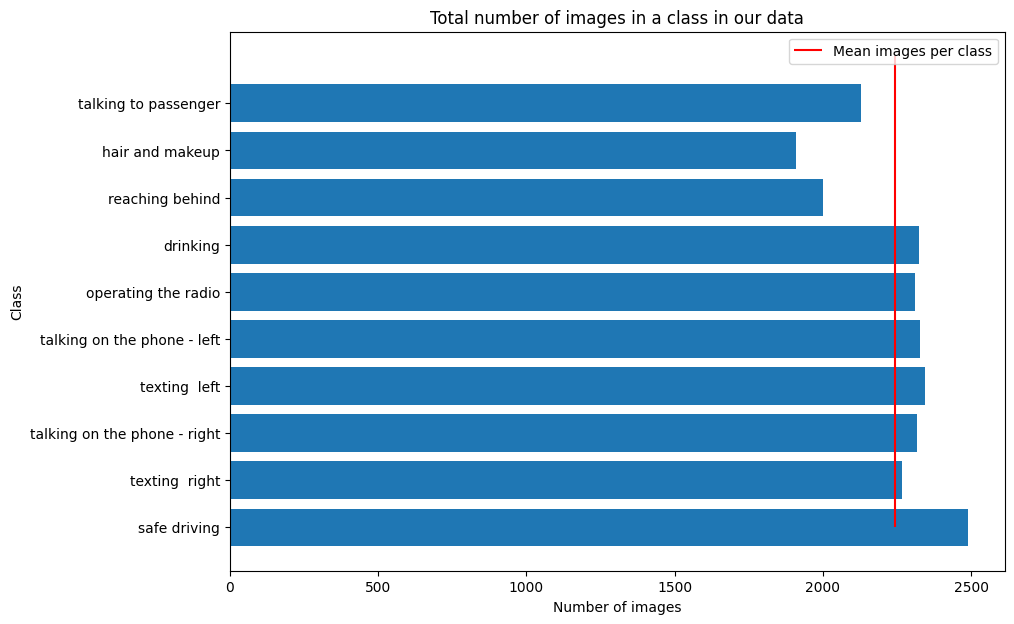

In [6]:
plt.figure(figsize=(10,7))

plt.barh(pd.Series((df_driver.classname.value_counts().sort_index().index.str.slice(start=-1))).apply(lambda x: classes_dict[int(x)]),df_driver.classname.value_counts().sort_index())
plt.vlines(df_driver.classname.value_counts().mean(),0,10, color='red', label='Mean images per class')
plt.xlabel('Number of images')
plt.ylabel('Class')
plt.legend()
plt.title('Total number of images in a class in our data')
plt.show()

We can understand from the above bar plot that the images in the dataset are fairly distributed among all the classes.

In [7]:
df_driver.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


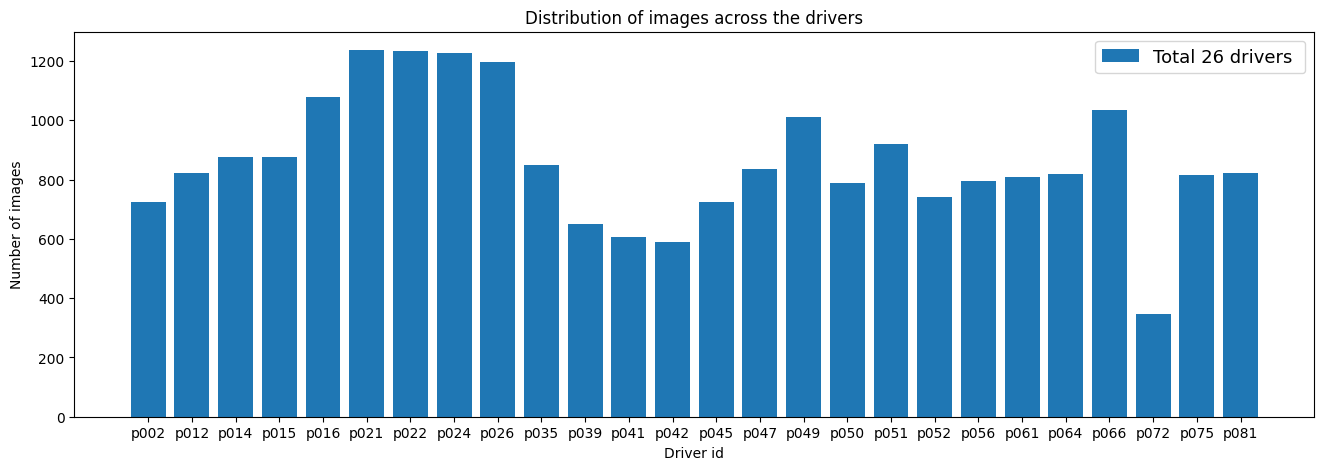

In [8]:
plt.figure(figsize=(16,5))

plt.bar(df_driver.subject.value_counts().sort_index().index, df_driver.subject.value_counts().sort_index(), label=f'Total {(df_driver.subject.unique()).shape[0]} drivers ')
plt.xlabel('Driver id')
plt.ylabel('Number of images')
plt.legend(fontsize=13)
plt.title('Distribution of images across the drivers')

plt.show()

  ## Visualising the augmentations

In [9]:
datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=False,width_shift_range=0.1, height_shift_range=0.1,shear_range=0.1,zoom_range=0.2,
                          validation_split=0.2)

train_gen=datagen.flow_from_directory(train_path, target_size=(240,320), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='training')

val_gen=datagen.flow_from_directory(train_path, target_size=(240,320), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [10]:
# Use __next__() to get the next batch from the generator
sample_batch = train_gen.__next__()

sample_imgs = sample_batch[0]
sample_labels = sample_batch[1]

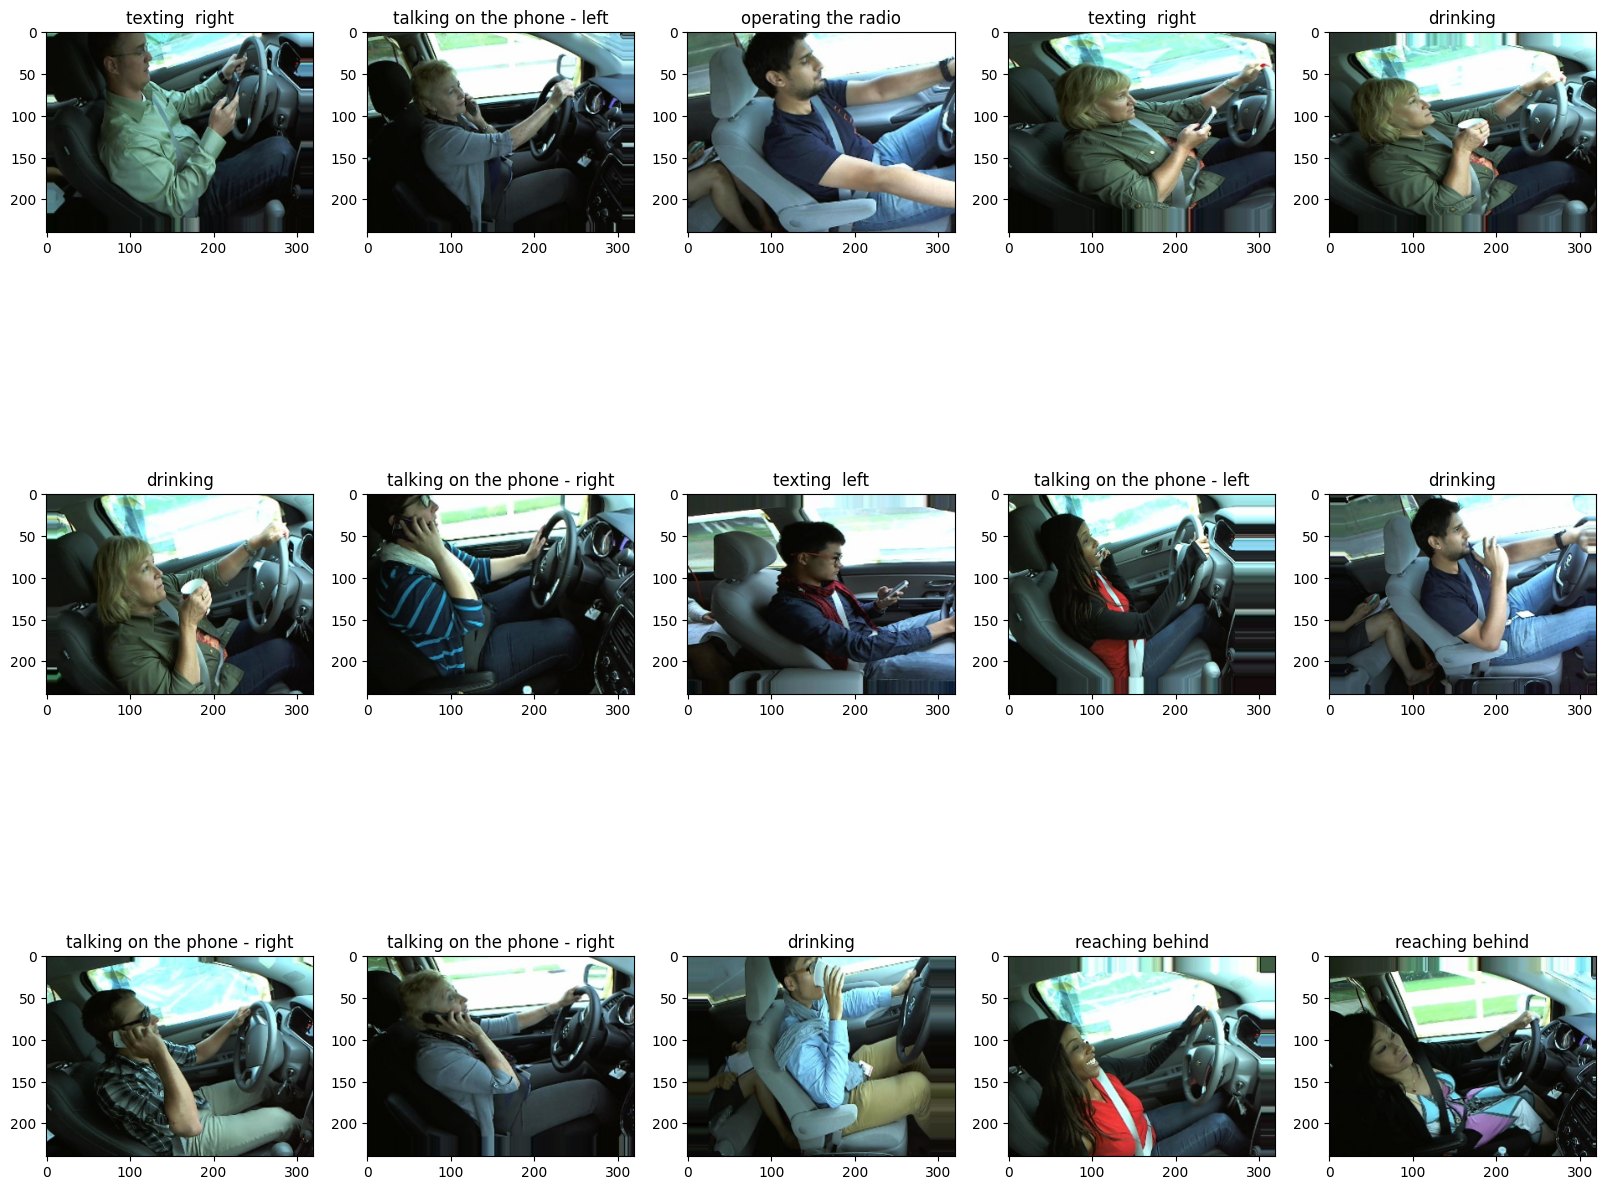

In [11]:
fig, ax= plt.subplots( ncols=5, nrows=3, figsize=(20,17))

ax=ax.ravel()
for i,(ax) in enumerate(ax):
  ax.imshow(sample_imgs[i])
  ax.set_title(f'{classes_dict[(np.argmax(sample_labels[i]))]}')

# Part 2: CNN model built and trained by us.

In [12]:
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen=datagen.flow_from_directory(directory = train_path, target_size=(64,64), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='training')

val_gen=datagen.flow_from_directory(directory = train_path, target_size=(64,64), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='validation')



Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [13]:
def create_model(img_rows, img_cols, color_type):
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(16,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(16,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model


In [14]:
model= create_model(64, 64, 3)

C:\Users\playb\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,413,530 (5.39 MB)

 Trainable params: 1,411,546 (5.38 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [16]:
model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['accuracy']) # Pass 'accuracy' as a list

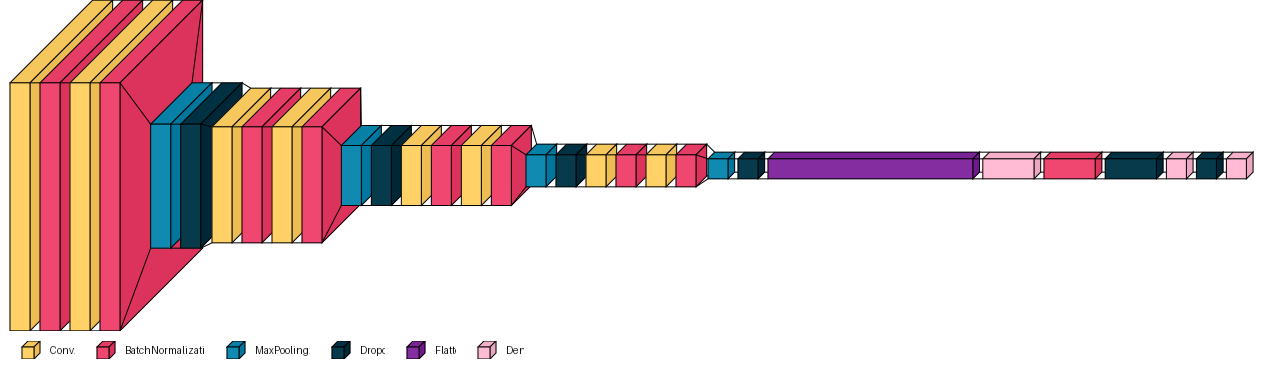

In [17]:
visualkeras.layered_view(model,legend=True)

In [18]:
history_scratch = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    # Remove use_multiprocessing and workers
    # Use the 'use_multiprocessing' argument within your data generators
    # (e.g., ImageDataGenerator) if needed.
)

Epoch 1/15


C:\Users\playb\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


561/561 ━━━━━━━━━━━━━━━━━━━━ 205s 351ms/step - accuracy: 0.2096 - loss: 2.5621 - val_accuracy: 0.5963 - val_loss: 1.2030
Epoch 2/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 77s 136ms/step - accuracy: 0.5904 - loss: 1.1140 - val_accuracy: 0.8795 - val_loss: 0.3591
Epoch 3/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 73s 129ms/step - accuracy: 0.8140 - loss: 0.5462 - val_accuracy: 0.9174 - val_loss: 0.2308
Epoch 4/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 75s 133ms/step - accuracy: 0.8824 - loss: 0.3563 - val_accuracy: 0.9531 - val_loss: 0.1603
Epoch 5/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 78s 139ms/step - accuracy: 0.9108 - loss: 0.2728 - val_accuracy: 0.9750 - val_loss: 0.0891
Epoch 6/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 73s 130ms/step - accuracy: 0.9328 - loss: 0.2199 - val_accuracy: 0.9705 - val_loss: 0.0996
Epoch 7/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - accuracy: 0.9467 - loss: 0.1785 - val_accuracy: 0.9748 - val_loss: 0.0740
Epoch 8/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - accuracy: 0.9505 - loss: 0.1594 - va

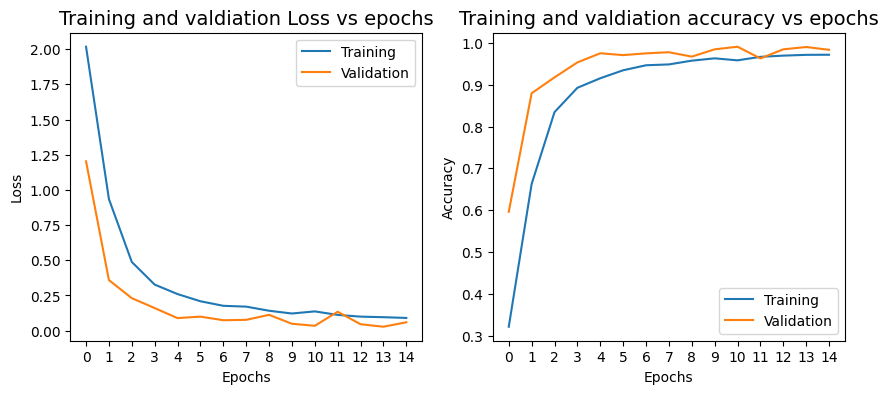

In [19]:
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(10,4))

ax[0].plot(history_scratch.history['loss'], label='Training')
ax[0].plot(history_scratch.history['val_loss'], label='Validation')
ax[0].set_xticks(list(range(0,15)))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Training and valdiation Loss vs epochs', fontsize=14)

ax[1].plot(history_scratch.history['accuracy'], label='Training')
ax[1].plot(history_scratch.history['val_accuracy'], label='Validation')
ax[1].set_xticks(list(range(0,15)))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title('Training and valdiation accuracy vs epochs', fontsize=14)

plt.show()

In [20]:
# Generate predictions on validation set
y_true = []  # True labels
y_pred = []  # Predicted labels

for i in range(len(val_gen)):
    images, labels = val_gen[i]
    predictions = model.predict(images)
    y_true.extend(labels.argmax(axis=1))  # Convert one-hot encoding to label index
    y_pred.extend(predictions.argmax(axis=1))  # Get the index of the max predicted probability

# Convert to numpy arrays for evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

In [21]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(classes_dict.values())))


Accuracy: 0.9833
Precision: 0.9835
Recall: 0.9833
F1 Score: 0.9833

Classification Report:
                              precision    recall  f1-score   support

                safe driving       0.95      0.99      0.97       497
              texting  right       0.98      1.00      0.99       453
talking on the phone - right       0.98      0.99      0.99       463
               texting  left       0.98      0.99      0.99       469
 talking on the phone - left       1.00      0.98      0.99       465
         operating the radio       1.00      0.98      0.99       462
                    drinking       0.99      0.98      0.99       465
             reaching behind       1.00      0.99      1.00       400
             hair and makeup       0.97      0.97      0.97       382
        talking to passenger       0.99      0.95      0.97       425

                    accuracy                           0.98      4481
                   macro avg       0.98      0.98      0.98      44

Accuracy: 0.9833
Precision: 0.9835
Recall: 0.9833
F1 Score: 0.9833


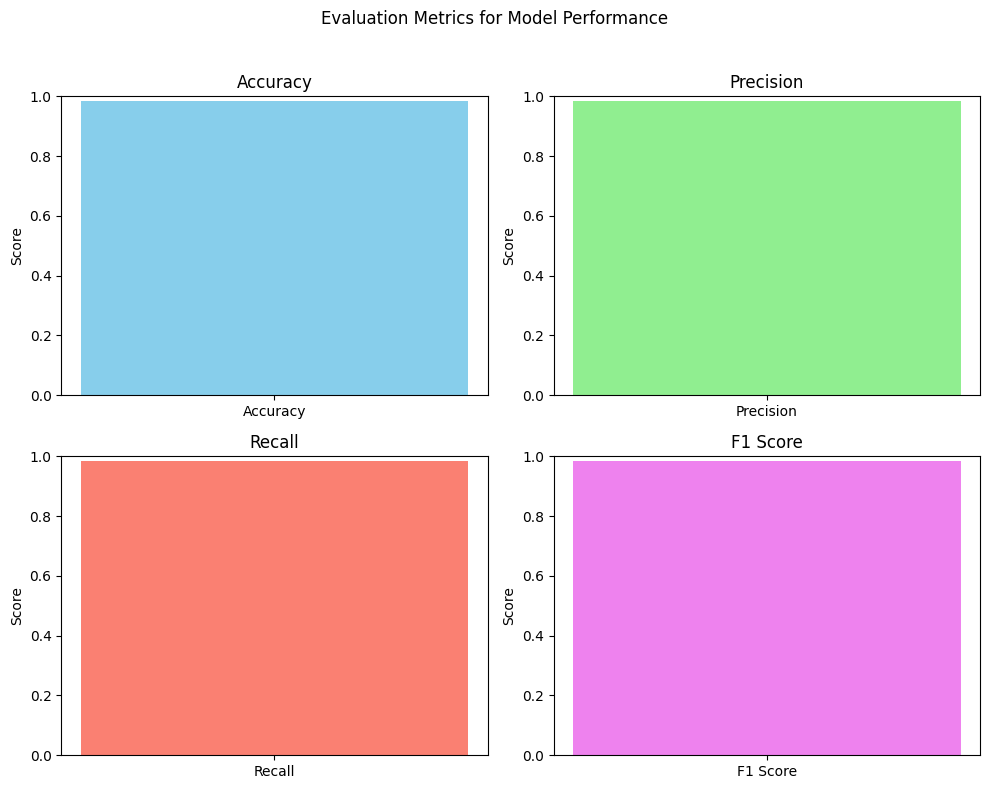

In [22]:
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot each metric in an individual bar chart
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Set up subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Evaluation Metrics for Model Performance')

# Plot Accuracy
axs[0, 0].bar(['Accuracy'], [accuracy], color='skyblue')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_title('Accuracy')

# Plot Precision
axs[0, 1].bar(['Precision'], [precision], color='lightgreen')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_ylabel('Score')
axs[0, 1].set_title('Precision')

# Plot Recall
axs[1, 0].bar(['Recall'], [recall], color='salmon')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_ylabel('Score')
axs[1, 0].set_title('Recall')

# Plot F1 Score
axs[1, 1].bar(['F1 Score'], [f1], color='violet')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_ylabel('Score')
axs[1, 1].set_title('F1 Score')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


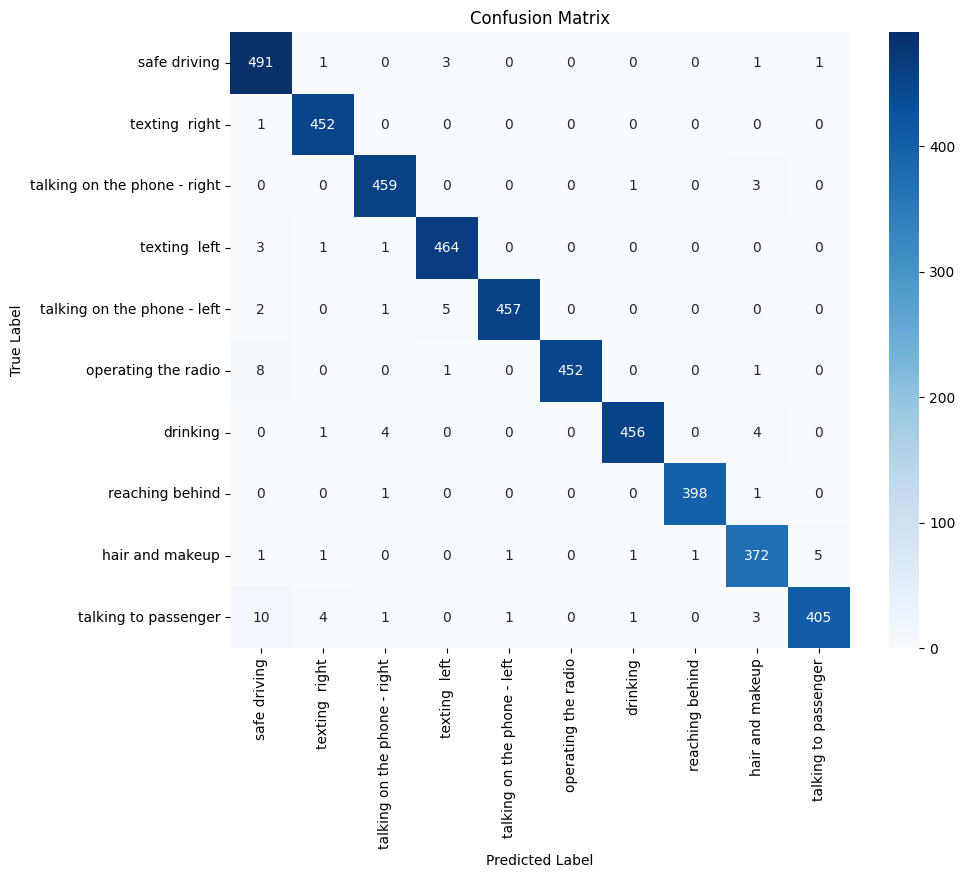

In [23]:
# Plot confusion matrix for detailed visualization
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(classes_dict.values()), yticklabels=list(classes_dict.values()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [24]:
model_json = model.to_json()
with open("saved models/model_.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("saved models/model_.weights.h5")
print("Saved model to disk")

Saved model to disk


# Part 3: Fine-Tuning EfficientNetB3

In [ ]:
datagen=ImageDataGenerator(width_shift_range=0.3, height_shift_range=0.3,shear_range=0.3,zoom_range=0.4,
                           validation_split=0.2)

train_gen=datagen.flow_from_directory(train_path, target_size=(240,320), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='training')

val_gen=datagen.flow_from_directory(train_path, target_size=(240,320), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [ ]:
base_model=EfficientNetB3(include_top=False, weights = 'imagenet', input_shape=(240,320,3))

In [ ]:

x = base_model.output

x = layers.GlobalAveragePooling2D()(x)

x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)

preds = layers.Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=preds, name='using_EfficientNetB3')


In [ ]:
model.summary()

Model: "using_EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 240, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 320,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 320,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 320,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 321,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 160,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 160,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 160,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 160,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 160,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 160,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 160,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 160,  │        960 │ block1a_se_excit

 Total params: 10,805,049 (41.22 MB)

 Trainable params: 10,714,674 (40.87 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
for layer in model.layers:
  layer.trainable=True

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy']) # Pass 'accuracy' as a list

In [ ]:
steps_per_epoch=17950 // 32
validation_steps=4483 // 32

In [ ]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    # Remove the 'workers' and 'use_multiprocessing' arguments
)

Epoch 1/10


C:\Users\playb\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


368/560 ━━━━━━━━━━━━━━━━━━━━ 21:02 7s/step - accuracy: 0.1570 - loss: 2.8898

KeyboardInterrupt: 

In [ ]:
model_json = model.to_json()
with open("saved models\model_EfficientNetB3.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("saved models\model_EfficientNetB3_.weights.h5")
print("Saved model to disk")

In [ ]:
visualkeras.layered_view(model,draw_volume=False ,legend=True)

We will be considering the fine-tuned EfficientNetB3 model for the visualisations and Error Analysis below, since this model seems to perform well.

# Part 4: Visualisations

#### Smooth-Grad and Grad-CAMs

In [ ]:
sample_batch = next(val_gen)

imgs = sample_batch[0]
labels = sample_batch[1]


In [ ]:
preds=model.predict(imgs)

correct_idx=np.where(np.argmax(labels, axis=1)==np.argmax(preds, axis=1))[0]
random_5_correct_idx=np.random.randint(0,correct_idx.shape[0], size=5)

In [ ]:
r2l=ReplaceToLinear()

fig,ax=plt.subplots(ncols=3, nrows=5,figsize=(12,18))

for i,idx in enumerate(random_5_correct_idx):

  img=imgs[correct_idx[idx]]
  label=np.argmax(labels[correct_idx[idx]])

  score=CategoricalScore([label])

  saliency=Saliency(model, model_modifier=r2l, clone=True)
  saliency_map=saliency(score, img, smooth_samples=20, smooth_noise=0.2)
  saliency_map=normalize(saliency_map)

  grad_cam=Gradcam(model, model_modifier=r2l, clone=True)
  cam=grad_cam(score,img, penultimate_layer=-1)
  cam=normalize(cam)

  ax1=ax[i][0]
  ax2=ax[i][1]
  ax3=ax[i][2]

  ax1.imshow(img/255)
  ax1.set_title(f'Label:{classes_dict[label]}')

  ax2.imshow(saliency_map.reshape(240,320), cmap='Greys')
  ax2.set_title('Smooth Grad')

  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax3.imshow(img/255)
  ax3.imshow(heatmap.reshape(240,320,3), cmap='jet', alpha=0.5)
  ax3.set_title('Grad Cam')

fig.suptitle('Visualising Smooth Grad and GradCam for Correctly predicted labels', fontsize=15)

plt.show()

#### Visualizing Dense layer using ActivationMaximization

In [ ]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress, PrintLogger
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

In [ ]:
seed_input = tf.random.uniform((10, 240, 320, 3), 0, 255)

In [ ]:
scores=CategoricalScore(list(range(0,10)))

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=r2l,
                                                 clone=True)
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])



In [ ]:
fig = plt.figure(figsize=(15, 18))

for i, label in enumerate(classes_dict.values()):
    ax = plt.subplot(4, 3, i + 1)
    
    # Convert TensorFlow tensor to a NumPy array
    activation = activations[i].numpy()
    
    # Normalize the activation data to [0, 1]
    activation_min = activation.min()
    activation_max = activation.max()
    activation_normalized = (activation - activation_min) / (activation_max - activation_min)
    
    ax.imshow(activation_normalized)
    ax.set_title(f'{label}', fontsize=16)
    ax.axis('off')

fig.suptitle('Visualising the dense layer using activation maximization', fontsize=15)
plt.tight_layout()
plt.show()


# Part 5: Error Analysis

In [ ]:
incorrect_imgs = np.zeros((0, 240, 320, 3))
incorrect_og_labels = np.zeros((0, 10))
incorrect_pred_labels = np.zeros((0, 10))

for _ in range(40):
    # Use next() function to get the next batch
    sample_batch = next(val_gen)
    imgs_array = sample_batch[0]
    labels_array = sample_batch[1]

    preds = model.predict(imgs_array)

    incorrect_idx = np.where(np.argmax(preds, axis=1) != np.argmax(labels_array, axis=1))[0]

    if incorrect_idx.shape != (0,):
        incorrect_imgs = np.concatenate((incorrect_imgs, imgs_array[incorrect_idx]), axis=0)
        incorrect_og_labels = np.concatenate((incorrect_og_labels, labels_array[incorrect_idx]), axis=0)
        incorrect_pred_labels = np.concatenate((incorrect_pred_labels, preds[incorrect_idx]), axis=0)


In [ ]:
random_idx_5=np.random.randint(0,incorrect_imgs.shape[0], size=5)

In [ ]:
r2l=ReplaceToLinear()

fig,ax=plt.subplots(ncols=3, nrows=5,figsize=(12,18))

for i,idx in enumerate(random_idx_5):

  img=incorrect_imgs[idx]
  label=np.argmax(incorrect_og_labels[idx])
  pred_label=np.argmax(incorrect_pred_labels[idx])

  score=CategoricalScore([pred_label])

  saliency=Saliency(model, model_modifier=r2l, clone=True)
  saliency_map=saliency(score, img, smooth_samples=20, smooth_noise=0.2)
  saliency_map=normalize(saliency_map)

  grad_cam=Gradcam(model, model_modifier=r2l, clone=True)
  cam=grad_cam(score,img, penultimate_layer=-1)
  cam=normalize(cam)

  ax1=ax[i][0]
  ax2=ax[i][1]
  ax3=ax[i][2]

  ax1.imshow(img/255)
  ax1.set_title(f'Original label:{classes_dict[label]} \n Predicted label:{classes_dict[pred_label]}')

  ax2.imshow(saliency_map.reshape(240,320), cmap='Greys')
  ax2.set_title('Smooth Grad')

  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax3.imshow(img/255)
  ax3.imshow(heatmap.reshape(240,320,3), cmap='jet', alpha=0.5)
  ax3.set_title('Grad Cam')

fig.suptitle('Visualising Smooth Grad and GradCam for incorrectly predicted labels', fontsize=15)

plt.show()

# Real time Detection


Using the harrcascadees library


In [ ]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.models import model_from_json

# Load emotion classification model
with open('state-farm-distracted-driver-detection/saved models/model_EfficientNetB3.json', 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)
model.load_weights("state-farm-distracted-driver-detection/saved models/model_EfficientNetB3_.weights.h5")

# Load the face detector
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Emotion labels
emotion_labels = [
    'safe driving', 'texting right', 'talking on the phone - right', 'texting left',
    'talking on the phone - left', 'operating the radio', 'drinking', 
    'reaching behind', 'hair and makeup', 'talking to passenger'
]

# Start the webcam feed
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_image, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        roi_gray = gray_image[y:y+h, x:x+w]
        # Resize the ROI to the expected input size of the model (240x320)
        roi_rgb = cv2.resize(roi_gray, (320, 240))
        
        # Convert grayscale image to RGB
        roi_rgb = cv2.cvtColor(roi_rgb, cv2.COLOR_GRAY2RGB)
        
        roi_rgb = roi_rgb.astype("float") / 255.0
        roi_rgb = img_to_array(roi_rgb)
        roi_rgb = np.expand_dims(roi_rgb, axis=0)

        preds = model.predict(roi_rgb)[0]
        label = emotion_labels[np.argmax(preds)]
        confidence = np.max(preds)

        # Display label and confidence on the bounding box
        label_text = f"{label} {confidence:.2f}"
        cv2.putText(frame, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow('Driver Behavior Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Using Yolo V8 Predefiled model


In [ ]:
! pip install ultralytics
import torch
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.models import model_from_json
from ultralytics import YOLO

# Load YOLOv8 model (make sure 'yolov8n.pt' is in your directory or provide full path)
yolo_model = YOLO('yolov8n.pt')

# Load emotion classification model
with open('state-farm-distracted-driver-detection/saved models/model_EfficientNetB3.json', 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)
model.load_weights("state-farm-distracted-driver-detection/saved models/model_EfficientNetB3_.weights.h5")

# Emotion labels
emotion_labels = [
    'safe driving', 'texting right', 'talking on the phone - right', 'texting left',
    'talking on the phone - left', 'operating the radio', 'drinking', 
    'reaching behind', 'hair and makeup', 'talking to passenger'
]

# Start the webcam feed
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Use YOLOv8 to detect objects (faces)
    results = yolo_model.predict(frame)

    # Loop through results (detections) and draw bounding boxes
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Extract bounding boxes
        confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
        class_ids = result.boxes.cls.cpu().numpy()  # Class IDs

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box[:4])  # Extract the box coordinates
            confidence = confidences[i]
            class_id = int(class_ids[i])

            # Only process faces (assuming you are detecting faces; adjust class_id as needed)
            # If you want to restrict to a specific class, e.g., 'person', check `class_id`
            
            # Draw a rectangle around the detected face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Extract and preprocess the face region for emotion classification
            roi_rgb = frame[y1:y2, x1:x2]  # Crop the face region
            if roi_rgb.size == 0:  # Skip invalid regions
                continue
            roi_rgb = cv2.resize(roi_rgb, ( 320 , 240))  # Resize for emotion classification model
            roi_rgb = roi_rgb.astype("float") / 255.0  # Normalize the pixel values
            roi_rgb = img_to_array(roi_rgb)
            roi_rgb = np.expand_dims(roi_rgb, axis=0)

            # Predict emotion
            preds = model.predict(roi_rgb)[0]
            label = emotion_labels[np.argmax(preds)]

            # Display the label and confidence score
            label_text = f"{label} {confidence:.2f}"
            cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the frame with detections
    cv2.imshow('Emotion Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import time

# Initialize the emotion counter
emotion_counter = Counter()

# Create a matplotlib figure for real-time plotting
plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots()

def update_graph(emotion_counter):
    ax.clear()
    emotions = list(emotion_counter.keys())
    counts = list(emotion_counter.values())
    ax.bar(emotions, counts)
    plt.xticks(rotation=45)
    plt.ylabel("Counts")
    plt.title("Emotion Detection Count Over Time")
    plt.draw()
    plt.pause(0.001)  # Pause to allow the figure to update

def save_final_graph(emotion_counter):
    """Save the final graph to a file when exiting the application."""
    fig, ax = plt.subplots()
    emotions = list(emotion_counter.keys())
    counts = list(emotion_counter.values())
    ax.bar(emotions, counts)
    plt.xticks(rotation=45)
    plt.ylabel("Counts")
    plt.title("Final Emotion Detection Count")
    # Save the figure to a file
    plt.savefig("emotion_detection_counts.png")
    print("Graph exported as 'emotion_detection_counts.png'.")

# Start the webcam feed
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Use YOLOv8 to detect objects (faces)
    results = yolo_model.predict(frame)

    # Loop through results (detections) and draw bounding boxes
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Extract bounding boxes
        confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
        class_ids = result.boxes.cls.cpu().numpy()  # Class IDs

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box[:4])  # Extract the box coordinates
            confidence = confidences[i]
            class_id = int(class_ids[i])

            # Only process faces (assuming you are detecting faces; adjust class_id as needed)
            # If you want to restrict to a specific class, e.g., 'person', check `class_id`
            
            # Draw a rectangle around the detected face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Extract and preprocess the face region for emotion classification
            roi_rgb = frame[y1:y2, x1:x2]  # Crop the face region
            if roi_rgb.size == 0:  # Skip invalid regions
                continue
            roi_rgb = cv2.resize(roi_rgb, (320, 240))  # Resize for emotion classification model
            roi_rgb = roi_rgb.astype("float") / 255.0  # Normalize the pixel values
            roi_rgb = img_to_array(roi_rgb)
            roi_rgb = np.expand_dims(roi_rgb, axis=0)

            # Predict emotion
            preds = model.predict(roi_rgb)[0]
            label = emotion_labels[np.argmax(preds)]

            # Update the emotion counter
            emotion_counter[label] += 1

            # Display the label and confidence score
            label_text = f"{label} {confidence:.2f}"
            cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Update the graph with the latest emotion count
            update_graph(emotion_counter)

    # Display the frame with detections
    cv2.imshow('Emotion Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

# Save the final emotion graph when exiting
save_final_graph(emotion_counter)
